# The Battle of the Neighborhoods

In this Notebook I will focus on the Brooklyn borough in New York and Cluster the existing venues 

### A description of the problem and a discussion of the background

I am an restaurant owner in a western area of New York. Since my business had a really good past year, our plan is to expand to further neighborhoods in New York and attract new customers with our delicious food. The current status is that there is no restaurant from us in the whole Brooklyn borough, which is actually a quite interesting area with a wide variety of potential visitors. In order to increase my influence and be able to sell my specialities, I decided to analysis the whole Brooklyn borough. The goal is to find a nice neighborhood with great growth potential.

### A description of the data

For my analysis I will use New York City data that contains all of New Yorks five boroughs with their respective neighborhoods, together with their latitude and  logitude values. The used source was provided in one of the coursera courses: https://cocl.us/new_york_dataset - and is importet by using pandas.
Next to that I will use the Foursquare API to create API calls to fetch for the top venues in the different neighborhoods of Brooklyn.
Next to that I will use a variety of python libraries such as pandas, mathplotlib, geopy - to get latitude and longitude values - , folium - to create maps - and more...

## Introduction 

### Business Problem

The Problem lies in finding a suitable neighborhood in New York City, more specifically in the borough of Brooklyn that allows me to expand my restaurant business. On one hand it is important to determine which neihgborhoods are alreday well populated with restaurants to indicate that the people in the respective neighborhood like to go out and eat in a restaurant. And on the other hand it is important to look where restaurants are among the most frequent venues so the overall competition is not too fierce and my newly opened venues has potential to grow next to all the already established restaurants.

### Who would be interested in this project/problem

i think this problem is applicable to many different people. The used methodologies can be applied for example in different cities and with all kinds of venues which make this problem easy to transfer. In this particular case the offered approach helps people in New York who are planning on opening a new venues in the borough of Brooklyn. The provided data helps to illustrate the distribution of different venues types and supports decision making. 

### What are interesting key questions

- What is the distribution of neighborhoods in New York
- What are good areas in Brooklyn to open a new venue
- What are the most frenquent venues in Brooklyns neighborhoods
- How can clustering help to make a decision

## Methodology section 

In [1]:
import numpy as np # library to handle data in a vectorized manner
import time
import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json # library to handle JSON files
import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe


!conda install -c conda-forge geopy --yes # uncomment this line if you haven't completed the Foursquare API lab
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

!conda install -c conda-forge folium=0.5.0 --yes # uncomment this line if you haven't completed the Foursquare API lab
import folium # map rendering library
import folium # map rendering library
from folium import plugins

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors
%matplotlib inline

import seaborn as sns

# import k-means from clustering stage
from sklearn.cluster import KMeans





from bs4 import BeautifulSoup

import os


import matplotlib.pyplot as plt


print('Libraries imported.')

Solving environment: done

## Package Plan ##

  environment location: /opt/conda/envs/Python36

  added / updated specs: 
    - geopy


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    geographiclib-1.50         |             py_0          34 KB  conda-forge
    geopy-1.21.0               |             py_0          58 KB  conda-forge
    certifi-2019.11.28         |           py36_0         149 KB  conda-forge
    ca-certificates-2019.11.28 |       hecc5488_0         145 KB  conda-forge
    openssl-1.1.1d             |       h516909a_0         2.1 MB  conda-forge
    ------------------------------------------------------------
                                           Total:         2.5 MB

The following NEW packages will be INSTALLED:

    geographiclib:   1.50-py_0         conda-forge
    geopy:           1.21.0-py_0       conda-forge

The following packages will be UPDATED:

    ca-

Here we define a function to get the longitude and latitude of a given address using geopy

In [2]:
def geo_location(address):
    # get geo location of address
    geolocator = Nominatim(user_agent="ny_explorer")
    location = geolocator.geocode(address)
    latitude = location.latitude
    longitude = location.longitude
    return latitude,longitude

Here we define a functoin to make an API request to the Foursquare API to get different venues

In [3]:
def get_venues(lat,lng):
    
    #set variables
    radius=1000
    LIMIT=100
    CLIENT_ID = 'IMSI5FWSXNYOTM4MCYFZF1IE5WKRWL3UDUPXE5VVQA0BLXWT' # your Foursquare ID
    CLIENT_SECRET = 'IC1P3CEWHQDD44OQLDYYEGS2NTHG0AL5PF3E0AEFMZ4UEJD3' # your Foursquare Secret
    VERSION = '20200216' # Foursquare API version
    
    #url to fetch data from foursquare api
    url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
    
    # get all the data
    results = requests.get(url).json()
    venue_data=results["response"]['groups'][0]['items']
    venue_details=[]
    for row in venue_data:
        try:
            venue_id=row['venue']['id']
            venue_name=row['venue']['name']
            venue_category=row['venue']['categories'][0]['name']
            venue_details.append([venue_id,venue_name,venue_category])
        except KeyError:
            pass
        
    column_names=['ID','Name','Category']
    df = pd.DataFrame(venue_details,columns=column_names)
    return df

Similar to the cell above, this code defines a function to get further venues details, also using the Foursquare API

In [4]:
def get_venue_details(venue_id):
        
    CLIENT_ID = 'IMSI5FWSXNYOTM4MCYFZF1IE5WKRWL3UDUPXE5VVQA0BLXWT' # your Foursquare ID
    CLIENT_SECRET = 'IC1P3CEWHQDD44OQLDYYEGS2NTHG0AL5PF3E0AEFMZ4UEJD3' # your Foursquare Secret
    VERSION = '20200216' # Foursquare API version
    
    #url to fetch data from foursquare api
    url = 'https://api.foursquare.com/v2/venues/{}?&client_id={}&client_secret={}&v={}'.format(
            venue_id,
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION)
    
    # get all the data
    results = requests.get(url).json()
    venue_data=results['response']['venue']
    venue_details=[]
    try:
        venue_id=venue_data['id']
        venue_name=venue_data['name']
        venue_likes=venue_data['likes']['count']
        venue_rating=venue_data['rating']
        venue_tips=venue_data['tips']['count']
        venue_details.append([venue_id,venue_name,venue_likes,venue_rating,venue_tips])
    except KeyError:
        pass
        
    column_names=['ID','Name','Likes','Rating','Tips']
    df = pd.DataFrame(venue_details,columns=column_names)
    return df

## Getting the New York data

Here we are using a New York dataset to load information about the boroughs, neighborhoods and their latitude and longitude values into a dataframe

In [ ]:
def get_new_york_data():
    url='https://cocl.us/new_york_dataset'
    resp=requests.get(url).json()
    # all data is present in features label
    features=resp['features']
    
    # define the dataframe columns
    column_names = ['Borough', 'Neighborhood', 'Latitude', 'Longitude'] 
    # instantiate the dataframe
    new_york_data = pd.DataFrame(columns=column_names)
    
    for data in features:
        borough = data['properties']['borough'] 
        neighborhood_name = data['properties']['name']
        
        neighborhood_latlon = data['geometry']['coordinates']
        neighborhood_lat = neighborhood_latlon[1]
        neighborhood_lon = neighborhood_latlon[0]
    
        new_york_data = new_york_data.append({'Borough': borough,
                                          'Neighborhood': neighborhood_name,
                                          'Latitude': neighborhood_lat,
                                          'Longitude': neighborhood_lon}, ignore_index=True)
    
    return new_york_data

In [ ]:


# get new york data
new_york_data=get_new_york_data()



In [ ]:
new_york_data.head()

,Borough,Neighborhood,Latitude,Longitude
0,Bronx,Wakefield,40.894705,-73.847201
1,Bronx,Co-op City,40.874294,-73.829939
2,Bronx,Eastchester,40.887556,-73.827806
3,Bronx,Fieldston,40.895437,-73.905643
4,Bronx,Riverdale,40.890834,-73.912585


In [ ]:
new_york_data.shape

(306, 4)

In [ ]:
new_york_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 306 entries, 0 to 305
Data columns (total 4 columns):
Borough         306 non-null object
Neighborhood    306 non-null object
Latitude        306 non-null float64
Longitude       306 non-null float64
dtypes: float64(2), object(2)
memory usage: 9.6+ KB


Now we are using the above dataframe to display the distribution of neighborhoods (plotted against the different boroughs)

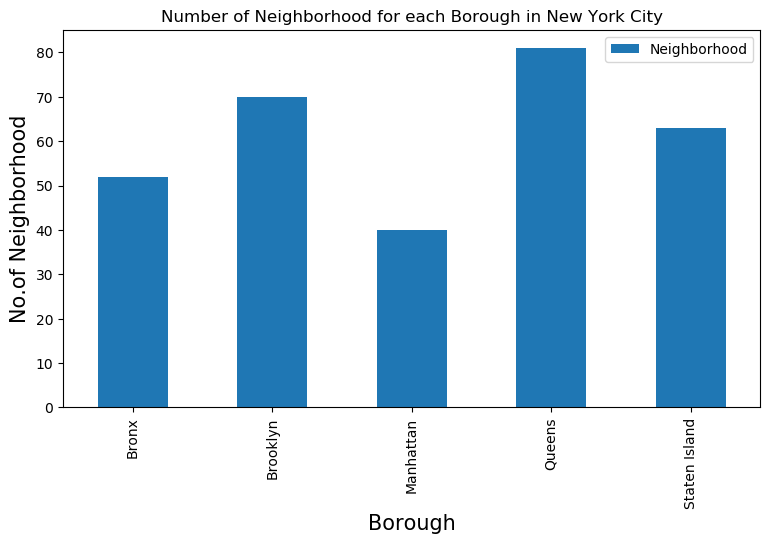

In [ ]:
plt.figure(figsize=(9,5), dpi = 100)
# title
plt.title('Number of Neighborhood for each Borough in New York City')
#On x-axis
plt.xlabel('Borough', fontsize = 15)
#On y-axis
plt.ylabel('No.of Neighborhood', fontsize=15)
#giving a bar plot
new_york_data.groupby('Borough')['Neighborhood'].count().plot(kind='bar')
#legend
plt.legend()
#displays the plot
plt.show()

The graph above shows that the New York dataframe has a total of five different boroughs. We can see that Queens is the borough with the highest number of neighborhoods, followed by Brooklyn, than Staten Island, Bronx and last but not least, Manhattan. Neighborhood-wise Manhattan is the smallest borough with almost half of the number of neighborhoods as Queens.

In [ ]:
new_york_data['Borough'].unique()

array(['Bronx', 'Manhattan', 'Brooklyn', 'Queens', 'Staten Island'],
      dtype=object)

### Using geopy to get the location data of New York

In [ ]:
address = 'New York City, NY'

geolocator = Nominatim(user_agent = 'NewYork Explorer')
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of New York City are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of New York City are 40.7127281, -74.0060152.


In [ ]:
# create map of New York using latitude and longitude values
map_newyork = folium.Map(location=[latitude, longitude], zoom_start=10)

# add markers to map
for lat, lng, borough, neighborhood in zip(new_york_data['Latitude'], new_york_data['Longitude'], new_york_data['Borough'], new_york_data['Neighborhood']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_newyork)  
    
map_newyork

This map shows us all the neighborhoods in New York

##  From here on we will focus on the famous Brooklyn borough and get further insights on what Brooklyn has to offer

In oder to do that we use our New York dataframe and limit it to the Brooklyn borough

In [ ]:
#limit it to Brooklyn

brooklyn_data = new_york_data[new_york_data['Borough'] == 'Brooklyn'].reset_index(drop=True)
brooklyn_data.head()

Here we are using geopy again to get the location data of the Brooklyn area


In [ ]:
address = 'Brooklyn, NY'

geolocator = Nominatim(user_agent = 'NewYork Explorer')
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Brooklyn are {}, {}.'.format(latitude, longitude))

In [ ]:

# create map of Brooklyn using latitude and longitude values
map_brooklyn = folium.Map(location=[latitude, longitude], zoom_start=11)

# add markers to map
for lat, lng, label in zip(brooklyn_data['Latitude'], brooklyn_data['Longitude'], brooklyn_data['Neighborhood']):
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_brooklyn)  
    
map_brooklyn

This map is essentially the same one we have created before but only shows the neighborhoods in Brooklyn

### Lets explorer a single neighborhood in Brooklyn:

In [ ]:
brooklyn_data.loc[18,'Neighborhood']

Since I am not from New York I decided on picking a rondom neighborhood within Brooklyn to continue my further analysis. By picking the number 18, it came to be that 'Brooklyn Heights' is the neighborhood of further interest. It is important to mention that the following steps could be applied to all neighborhoods of interest. So for example if someone is interest in opening a new venue in a different neighborhood, it might be better to then look into the venues within that particular neighborhood and its surroundings.

Again using geopy to get the coordinates of 'Brooklyn Heights'

In [ ]:
#Brooklyn Heights Latitude and Longitude values

neighborhood_latitude = brooklyn_data.loc[18, 'Latitude'] # neighborhood latitude value
neighborhood_longitude = brooklyn_data.loc[18, 'Longitude'] # neighborhood longitude value

neighborhood_name = brooklyn_data.loc[18, 'Neighborhood'] # neighborhood name

print('Latitude and longitude values of {} are {}, {}.'.format(neighborhood_name, 
                                                               neighborhood_latitude, 
                                                               neighborhood_longitude))

## Now we will use the Foursquare API the get tje top 100 venues in Brooklyn Heights

First of all we create a url which we need for sending the request. We limit the search to 100 venues within a radius of 500

In [19]:
# type your answer here
CLIENT_ID = 'IMSI5FWSXNYOTM4MCYFZF1IE5WKRWL3UDUPXE5VVQA0BLXWT' # your Foursquare ID
CLIENT_SECRET = 'IC1P3CEWHQDD44OQLDYYEGS2NTHG0AL5PF3E0AEFMZ4UEJD3' # your Foursquare Secret
VERSION = '20200216' # Foursquare API version
LIMIT = 100
radius = 500
url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
    CLIENT_ID, 
    CLIENT_SECRET, 
    VERSION, 
    neighborhood_latitude, 
    neighborhood_longitude, 
    radius, 
    LIMIT)

url

In [20]:
#Send the GET request
results = requests.get(url).json()

In [21]:
# function that extracts the category of the venue
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

In [22]:
venues = results['response']['groups'][0]['items']
    
nearby_venues = json_normalize(venues) # flatten JSON

# filter columns
filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
nearby_venues =nearby_venues.loc[:, filtered_columns]

# filter the category for each row
nearby_venues['venue.categories'] = nearby_venues.apply(get_category_type, axis=1)

# clean columns
nearby_venues.columns = [col.split(".")[-1] for col in nearby_venues.columns]

nearby_venues.head()

In [23]:
print('{} venues were returned by Foursquare.'.format(nearby_venues.shape[0]))

In [24]:
nearby_venues['categories'].unique()

This array show us all the differnt venue categories that were retrieved using the Foursquare API. Within the limit of 100 request we still have 66 different categories. Therefor we can conclude that the venue diversity in the Neighborhood 'Brooklyn Heights' is pretty strong and indicates that there might be different consumer clusters.

## Now we remove our focus and look at the situation in Brooklyn

We use the Foursquare API again to get information about the venues in Brooklyn. The important difference is that we do not use a limit on the API request.

In [25]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        #print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    print('Found {} venues in {} neighborhoods.'.format(nearby_venues.shape[0], len(venues_list)))
    
    return(nearby_venues)

In [26]:
brooklyn_venues = getNearbyVenues(names=brooklyn_data['Neighborhood'],
                                   latitudes=brooklyn_data['Latitude'],
                                   longitudes=brooklyn_data['Longitude'])

Found 2789 venues in 70 neighborhoods.


With our call we retrieved 2791 venues in all Neighborhoods in Brooklyn combined.

In [27]:
brooklyn_venues.head()

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Bay Ridge,40.625801,-74.030621,Pilo Arts Day Spa and Salon,40.624748,-74.030591,Spa
1,Bay Ridge,40.625801,-74.030621,Bagel Boy,40.627896,-74.029335,Bagel Shop
2,Bay Ridge,40.625801,-74.030621,Leo's Casa Calamari,40.624200,-74.030931,Pizza Place
3,Bay Ridge,40.625801,-74.030621,Cocoa Grinder,40.623967,-74.030863,Juice Bar
4,Bay Ridge,40.625801,-74.030621,Pegasus Cafe,40.623168,-74.031186,Breakfast Spot


The following show the number of venues for each neigborhood in alphabetical order

In [28]:

brooklyn_venues.groupby('Neighborhood').count()

,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighborhood,,,,,,
Bath Beach,47,47,47,47,47,47
Bay Ridge,84,84,84,84,84,84
Bedford Stuyvesant,28,28,28,28,28,28
Bensonhurst,33,33,33,33,33,33
Bergen Beach,6,6,6,6,6,6
Boerum Hill,90,90,90,90,90,90
Borough Park,20,20,20,20,20,20
Brighton Beach,45,45,45,45,45,45
Broadway Junction,12,12,12,12,12,12


We can see that Mill Island only has two venues, whereas Brooklyn Heights, Caroll Gardens, Cobble Hill, Downtown, Greenpoint, North Side and South Side all have 100 venues (which is the cap for the individual neighborhood).

## Preparing Clustering

one hot encoding

In [29]:
# one hot encoding
brooklyn_onehot = pd.get_dummies(brooklyn_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
brooklyn_onehot['Neighborhood'] = brooklyn_venues['Neighborhood'] 

# move neighborhood column to the first column
#fixed_columns = [scarborough_onehot.columns[-1]] + list(scarborough_onehot.columns[:-1])
#scarborough_onehot = scarborough_onehot[fixed_columns]

neighbor = brooklyn_onehot['Neighborhood']
brooklyn_onehot.drop(labels=['Neighborhood'], axis=1,inplace = True)
brooklyn_onehot.insert(0, 'Neighborhood', neighbor)

brooklyn_onehot.head()

,Neighborhood,Accessories Store,Adult Boutique,American Restaurant,Antique Shop,Arepa Restaurant,Argentinian Restaurant,Art Gallery,Arts & Crafts Store,Arts & Entertainment,Asian Restaurant,Athletics & Sports,Auto Dealership,Auto Garage,BBQ Joint,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Baseball Stadium,Basketball Court,Beach,Beer Bar,Beer Garden,Beer Store,Big Box Store,Bike Rental / Bike Share,Bike Shop,Bistro,Board Shop,Boat or Ferry,Bookstore,Boutique,Boxing Gym,Breakfast Spot,Brewery,Bridge,Bubble Tea Shop,Buffet,Burger Joint,Burrito Place,Bus Station,Bus Stop,Business Service,Butcher,Café,Cajun / Creole Restaurant,Candy Store,Cantonese Restaurant,Caribbean Restaurant,Caucasian Restaurant,Cha Chaan Teng,Check Cashing Service,Cheese Shop,Chinese Restaurant,Chocolate Shop,Church,Climbing Gym,Clothing Store,Cocktail Bar,Coffee Shop,Concert Hall,Convenience Store,Cosmetics Shop,Coworking Space,Creperie,Cuban Restaurant,Cycle Studio,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Distillery,Dive Bar,Dog Run,Donut Shop,Dry Cleaner,Dumpling Restaurant,Eastern European Restaurant,Electronics Store,Entertainment Service,Ethiopian Restaurant,Event Space,Factory,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant,Field,Filipino Restaurant,Fish & Chips Shop,Fish Market,Flower Shop,Food,Food & Drink Shop,Food Court,Food Stand,Food Truck,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Fruit & Vegetable Store,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gas Station,Gastropub,Gay Bar,General Entertainment,German Restaurant,Gift Shop,Golf Course,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Gymnastics Gym,Harbor / Marina,Hardware Store,Hawaiian Restaurant,Health & Beauty Service,Health Food Store,Herbs & Spices Store,Historic Site,History Museum,Home Service,Hookah Bar,Hostel,Hot Dog Joint,Hotel,Hotpot Restaurant,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indie Theater,Israeli Restaurant,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Jewish Restaurant,Juice Bar,Karaoke Bar,Kebab Restaurant,Kids Store,Korean Restaurant,Kosher Restaurant,Latin American Restaurant,Laundry Service,Library,Lingerie Store,Liquor Store,Locksmith,Lounge,Market,Martial Arts Dojo,Massage Studio,Mattress Store,Mediterranean Restaurant,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Mobile Phone Shop,Monument / Landmark,Motorcycle Shop,Movie Theater,Moving Target,Museum,Music Store,Music Venue,Nail Salon,New American Restaurant,Nightclub,Non-Profit,Noodle House,North Indian Restaurant,Opera House,Optical Shop,Organic Grocery,Other Great Outdoors,Other Nightlife,Other Repair Shop,Outdoors & Recreation,Outlet Store,Pakistani Restaurant,Paper / Office Supplies Store,Park,Performing Arts Venue,Peruvian Restaurant,Pet Store,Pharmacy,Pie Shop,Piercing Parlor,Pilates Studio,Pizza Place,Playground,Plaza,Poke Place,Polish Restaurant,Pool,Pool Hall,Pub,Racetrack,Ramen Restaurant,Record Shop,Rental Car Location,Rental Service,Residential Building (Apartment / Condo),Restaurant,Rock Club,Roof Deck,Russian Restaurant,Sake Bar,Salad Place,Salon / Barbershop,Sandwich Place,Scenic Lookout,Sculpture Garden,Seafood Restaurant,Shabu-Shabu Restaurant,Shanghai Restaurant,Shipping Store,Shoe Store,Shop & Service,Shopping Mall,Skating Rink,Ski Area,Smoke Shop,Snack Place,Soccer Field,South American Restaurant,Southern / Soul Food Restaurant,Spa,Spanish Restaurant,Speakeasy,Sporting Goods Shop,Sports Bar,Stadium,Stationery Store,Steakhouse,Supermarket,Supplement Shop,Surf Spot,Sushi Restaurant,Taco Place,Taiwanese Restaurant,Tapas Restaurant,Tattoo Parlor,Tea Room,Tennis Court,Thai Restaurant,Theater,Theme Park Ride / Attraction,Thrift / Vintage Store,Tibetan Restaurant,Tiki Bar,Toy / Game Store,Trail,Turkish Restaurant,Used Bookstore,Vape Store,Varenyky restaurant,Vegetarian / Vegan Restaurant,Video Game Store,Video Store,V

In [30]:
brooklyn_grouped = brooklyn_onehot.groupby('Neighborhood').mean().reset_index()
brooklyn_grouped

,Neighborhood,Accessories Store,Adult Boutique,American Restaurant,Antique Shop,Arepa Restaurant,Argentinian Restaurant,Art Gallery,Arts & Crafts Store,Arts & Entertainment,Asian Restaurant,Athletics & Sports,Auto Dealership,Auto Garage,BBQ Joint,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Baseball Stadium,Basketball Court,Beach,Beer Bar,Beer Garden,Beer Store,Big Box Store,Bike Rental / Bike Share,Bike Shop,Bistro,Board Shop,Boat or Ferry,Bookstore,Boutique,Boxing Gym,Breakfast Spot,Brewery,Bridge,Bubble Tea Shop,Buffet,Burger Joint,Burrito Place,Bus Station,Bus Stop,Business Service,Butcher,Café,Cajun / Creole Restaurant,Candy Store,Cantonese Restaurant,Caribbean Restaurant,Caucasian Restaurant,Cha Chaan Teng,Check Cashing Service,Cheese Shop,Chinese Restaurant,Chocolate Shop,Church,Climbing Gym,Clothing Store,Cocktail Bar,Coffee Shop,Concert Hall,Convenience Store,Cosmetics Shop,Coworking Space,Creperie,Cuban Restaurant,Cycle Studio,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Distillery,Dive Bar,Dog Run,Donut Shop,Dry Cleaner,Dumpling Restaurant,Eastern European Restaurant,Electronics Store,Entertainment Service,Ethiopian Restaurant,Event Space,Factory,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant,Field,Filipino Restaurant,Fish & Chips Shop,Fish Market,Flower Shop,Food,Food & Drink Shop,Food Court,Food Stand,Food Truck,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Fruit & Vegetable Store,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gas Station,Gastropub,Gay Bar,General Entertainment,German Restaurant,Gift Shop,Golf Course,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Gymnastics Gym,Harbor / Marina,Hardware Store,Hawaiian Restaurant,Health & Beauty Service,Health Food Store,Herbs & Spices Store,Historic Site,History Museum,Home Service,Hookah Bar,Hostel,Hot Dog Joint,Hotel,Hotpot Restaurant,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indie Theater,Israeli Restaurant,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Jewish Restaurant,Juice Bar,Karaoke Bar,Kebab Restaurant,Kids Store,Korean Restaurant,Kosher Restaurant,Latin American Restaurant,Laundry Service,Library,Lingerie Store,Liquor Store,Locksmith,Lounge,Market,Martial Arts Dojo,Massage Studio,Mattress Store,Mediterranean Restaurant,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Mobile Phone Shop,Monument / Landmark,Motorcycle Shop,Movie Theater,Moving Target,Museum,Music Store,Music Venue,Nail Salon,New American Restaurant,Nightclub,Non-Profit,Noodle House,North Indian Restaurant,Opera House,Optical Shop,Organic Grocery,Other Great Outdoors,Other Nightlife,Other Repair Shop,Outdoors & Recreation,Outlet Store,Pakistani Restaurant,Paper / Office Supplies Store,Park,Performing Arts Venue,Peruvian Restaurant,Pet Store,Pharmacy,Pie Shop,Piercing Parlor,Pilates Studio,Pizza Place,Playground,Plaza,Poke Place,Polish Restaurant,Pool,Pool Hall,Pub,Racetrack,Ramen Restaurant,Record Shop,Rental Car Location,Rental Service,Residential Building (Apartment / Condo),Restaurant,Rock Club,Roof Deck,Russian Restaurant,Sake Bar,Salad Place,Salon / Barbershop,Sandwich Place,Scenic Lookout,Sculpture Garden,Seafood Restaurant,Shabu-Shabu Restaurant,Shanghai Restaurant,Shipping Store,Shoe Store,Shop & Service,Shopping Mall,Skating Rink,Ski Area,Smoke Shop,Snack Place,Soccer Field,South American Restaurant,Southern / Soul Food Restaurant,Spa,Spanish Restaurant,Speakeasy,Sporting Goods Shop,Sports Bar,Stadium,Stationery Store,Steakhouse,Supermarket,Supplement Shop,Surf Spot,Sushi Restaurant,Taco Place,Taiwanese Restaurant,Tapas Restaurant,Tattoo Parlor,Tea Room,Tennis Court,Thai Restaurant,Theater,Theme Park Ride / Attraction,Thrift / Vintage Store,Tibetan Restaurant,Tiki Bar,Toy / Game Store,Trail,Turkish Restaurant,Used Bookstore,Vape Store,Varenyky restaurant,Vegetarian / Vegan Restaurant,Video Game Store,Video Store,V

Showing the top 5 venues for each neighborhood based on the one hot encoding. This gives us an overview about the most frequent venues in Brooklyn (which are unsurprinsingly restaurants and bars)

In [31]:
num_top_venues = 5

for hood in brooklyn_grouped['Neighborhood']:
    print("----"+hood+"----")
    temp = brooklyn_grouped[brooklyn_grouped['Neighborhood'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----Bath Beach----
                  venue  freq
0    Chinese Restaurant  0.06
1           Pizza Place  0.06
2              Pharmacy  0.06
3       Bubble Tea Shop  0.04
4  Fast Food Restaurant  0.04


----Bay Ridge----
                venue  freq
0  Italian Restaurant  0.07
1                 Spa  0.06
2         Pizza Place  0.06
3                 Bar  0.04
4  Chinese Restaurant  0.04


----Bedford Stuyvesant----
         venue  freq
0          Bar  0.07
1  Pizza Place  0.07
2  Coffee Shop  0.07
3         Café  0.07
4     Bus Stop  0.07


----Bensonhurst----
                venue  freq
0  Chinese Restaurant  0.12
1                Park  0.09
2          Donut Shop  0.06
3  Italian Restaurant  0.06
4    Sushi Restaurant  0.06


----Bergen Beach----
                venue  freq
0     Harbor / Marina  0.33
1      Baseball Field  0.17
2          Donut Shop  0.17
3          Playground  0.17
4  Athletics & Sports  0.17


----Boerum Hill----
                    venue  freq
0             Coffee Sh

In [32]:
#Function to sort venues in descending order
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

We do the same as above but now for the top 10 venues of each neighborhood to have a little broader picture

In [33]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = brooklyn_grouped['Neighborhood']

for ind in np.arange(brooklyn_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(brooklyn_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Bath Beach,Pizza Place,Chinese Restaurant,Pharmacy,Italian Restaurant,Bubble Tea Shop,Fast Food Restaurant,Donut Shop,Sushi Restaurant,Dessert Shop,Dim Sum Restaurant
1,Bay Ridge,Italian Restaurant,Pizza Place,Spa,American Restaurant,Greek Restaurant,Chinese Restaurant,Bar,Bagel Shop,Pharmacy,Playground
2,Bedford Stuyvesant,Pizza Place,Café,Bar,Coffee Shop,Bus Stop,Gourmet Shop,Gift Shop,Boutique,Fried Chicken Joint,New American Restaurant
3,Bensonhurst,Chinese Restaurant,Park,Italian Restaurant,Bakery,Sushi Restaurant,Donut Shop,Pizza Place,Ice Cream Shop,Pet Store,Hotpot Restaurant
4,Bergen Beach,Harbor / Marina,Baseball Field,Playground,Donut Shop,Athletics & Sports,Yoga Studio,Fish Market,Farmers Market,Fast Food Restaurant,Field
5,Boerum Hill,Coffee Shop,Dance Studio,Bar,Furniture / Home Store,French Restaurant,Sandwich Place,Arts & Crafts Store,Bakery,Yoga Studio,Boutique
6,Borough Park,Bank,Pizza Place,Pharmacy,Deli / Bodega,Farmers Market,Liquor Store,Fast Food Restaurant,Coffee Shop,Bakery,Kosher Restaurant
7,Brighton Beach,Beach,Eastern European Restaurant,Restaurant,Russian Restaurant,Sushi Restaurant,Mobile Phone Shop,Pharmacy,Bank,Gourmet Shop,Supplement Shop
8,Broadway Junction,Fried Chicken Joint,Diner,Donut Shop,Ice Cream Shop,Caribbean Restaurant,Burger Joint,Bus Station,Sandwich Place,Gas Station,Fish Market
9,Brooklyn Heights,Yoga Studio,Park,Italian Restaurant,Gym,Bakery,Deli / Bodega,Cosmetics Shop,Pizza Place,Gym / Fitness Center,Mexican Restaurant


# Clustering Brooklyns Boroughs with K-means

In [34]:
# set number of clusters
kclusters = 5

brooklyn_grouped_clustering = brooklyn_grouped.drop('Neighborhood', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=2).fit(brooklyn_grouped_clustering)

# check cluster labels generated for each row in the dataframe
#kmeans.labels_[0:10] 
kmeans.labels_



array([0, 2, 2, 2, 0, 2, 0, 0, 4, 2, 2, 2, 4, 2, 0, 2, 2, 4, 0, 0, 0, 2,
       2, 0, 4, 0, 2, 4, 4, 4, 2, 0, 2, 0, 0, 2, 0, 2, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 3, 0, 2, 0, 0, 1, 2, 2, 0, 4, 2, 4, 4, 0, 2, 2, 4, 0, 2,
       2, 2, 2, 4], dtype=int32)

We merge our Brooklyn dataframe with the dataframe showing the top 10 venues for each neighborhood which basically adds the latitude and longitude values

In [35]:
brooklyn_merged = brooklyn_data

# add clustering labels
brooklyn_merged['Cluster Labels'] = kmeans.labels_


brooklyn_merged = brooklyn_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood')

brooklyn_merged.head() # check the last columns!

,Borough,Neighborhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Brooklyn,Bay Ridge,40.625801,-74.030621,0,Italian Restaurant,Pizza Place,Spa,American Restaurant,Greek Restaurant,Chinese Restaurant,Bar,Bagel Shop,Pharmacy,Playground
1,Brooklyn,Bensonhurst,40.611009,-73.995180,2,Chinese Restaurant,Park,Italian Restaurant,Bakery,Sushi Restaurant,Donut Shop,Pizza Place,Ice Cream Shop,Pet Store,Hotpot Restaurant
2,Brooklyn,Sunset Park,40.645103,-74.010316,2,Mexican Restaurant,Bakery,Latin American Restaurant,Bank,Pizza Place,Mobile Phone Shop,Gym,Deli / Bodega,Fried Chicken Joint,Creperie
3,Brooklyn,Greenpoint,40.730201,-73.954241,2,Bar,Pizza Place,Cocktail Bar,Coffee Shop,Yoga Studio,French Restaurant,Café,Record Shop,Sushi Restaurant,Mexican Restaurant
4,Brooklyn,Gravesend,40.595260,-73.973471,0,Italian Restaurant,Pizza Place,Bus Station,Bakery,Martial Arts Dojo,Lounge,Music Store,Spa,Sporting Goods Shop,Metro Station


Now we create a map to display the clusters

In [36]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i+x+(i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(brooklyn_merged['Latitude'], brooklyn_merged['Longitude'], brooklyn_merged['Neighborhood'], brooklyn_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

now we can examine each cluster individually. Therefor we separate them based on their cluster labels.

In [37]:
brooklyn_cluster_0 = brooklyn_merged.loc[brooklyn_merged['Cluster Labels'] == 0, brooklyn_merged.columns[[1] + list(range(4, brooklyn_merged.shape[1]))]]

brooklyn_cluster_1 = brooklyn_merged.loc[brooklyn_merged['Cluster Labels'] == 1, brooklyn_merged.columns[[1] + list(range(4, brooklyn_merged.shape[1]))]]

brooklyn_cluster_2 = brooklyn_merged.loc[brooklyn_merged['Cluster Labels'] == 2, brooklyn_merged.columns[[1] + list(range(4, brooklyn_merged.shape[1]))]]

brooklyn_cluster_3 = brooklyn_merged.loc[brooklyn_merged['Cluster Labels'] == 3, brooklyn_merged.columns[[1] + list(range(4, brooklyn_merged.shape[1]))]]

brooklyn_cluster_4 = brooklyn_merged.loc[brooklyn_merged['Cluster Labels'] == 4, brooklyn_merged.columns[[1] + list(range(4, brooklyn_merged.shape[1]))]]

In [38]:
brooklyn_cluster_0

,Neighborhood,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Bay Ridge,0,Italian Restaurant,Pizza Place,Spa,American Restaurant,Greek Restaurant,Chinese Restaurant,Bar,Bagel Shop,Pharmacy,Playground
4,Gravesend,0,Italian Restaurant,Pizza Place,Bus Station,Bakery,Martial Arts Dojo,Lounge,Music Store,Spa,Sporting Goods Shop,Metro Station
6,Sheepshead Bay,0,Dessert Shop,Turkish Restaurant,Sandwich Place,Grocery Store,Pizza Place,Diner,Creperie,Park,Restaurant,Outlet Store
7,Manhattan Terrace,0,Ice Cream Shop,Pizza Place,Donut Shop,Grocery Store,Cosmetics Shop,Mobile Phone Shop,Steakhouse,Organic Grocery,Chinese Restaurant,Coffee Shop
14,Brownsville,0,Restaurant,Chinese Restaurant,Moving Target,Park,Plaza,Fried Chicken Joint,Farmers Market,Spanish Restaurant,Trail,Performing Arts Venue
18,Brooklyn Heights,0,Yoga Studio,Park,Italian Restaurant,Gym,Bakery,Deli / Bodega,Cosmetics Shop,Pizza Place,Gym / Fitness Center,Mexican Restaurant
19,Cobble Hill,0,Pizza Place,Bar,Playground,Coffee Shop,Ice Cream Shop,Italian Restaurant,Deli / Bodega,Cocktail Bar,Yoga Studio,Thai Restaurant
20,Carroll Gardens,0,Italian Restaurant,Coffee Shop,Pizza Place,Cocktail Bar,Wine Shop,Spa,Bar,Bakery,Gym / Fitness Center,Gift Shop
23,Fort Greene,0,Italian Restaurant,Pizza Place,Wine Shop,Flower Shop,Coffee Shop,Theater,French Restaurant,Farmers Market,Opera House,Performing Arts Venue
25,Cypress Hills,0,Fried Chicken Joint,Pizza Place,Fast Food Restaurant,Metro Station,Latin American Restaurant,Ice Cream Shop,Bakery,Mexican Restaurant,Seafood Restaurant,Liquor Store


In [39]:
brooklyn_cluster_1

,Neighborhood,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
52,Ocean Parkway,1,Liquor Store,Sake Bar,Paper / Office Supplies Store,Spa,Playground,Nightclub,Steakhouse,Supermarket,General Entertainment,Gym


In [40]:
brooklyn_cluster_2

,Neighborhood,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
1,Bensonhurst,2,Chinese Restaurant,Park,Italian Restaurant,Bakery,Sushi Restaurant,Donut Shop,Pizza Place,Ice Cream Shop,Pet Store,Hotpot Restaurant
2,Sunset Park,2,Mexican Restaurant,Bakery,Latin American Restaurant,Bank,Pizza Place,Mobile Phone Shop,Gym,Deli / Bodega,Fried Chicken Joint,Creperie
3,Greenpoint,2,Bar,Pizza Place,Cocktail Bar,Coffee Shop,Yoga Studio,French Restaurant,Café,Record Shop,Sushi Restaurant,Mexican Restaurant
5,Brighton Beach,2,Beach,Eastern European Restaurant,Restaurant,Russian Restaurant,Sushi Restaurant,Mobile Phone Shop,Pharmacy,Bank,Gourmet Shop,Supplement Shop
9,Crown Heights,2,Pizza Place,Museum,Café,Bagel Shop,Coffee Shop,Fried Chicken Joint,Supermarket,Candy Store,Farmers Market,Salon / Barbershop
10,East Flatbush,2,Department Store,Park,Food & Drink Shop,Supermarket,Fast Food Restaurant,Caribbean Restaurant,Moving Target,Bakery,Hardware Store,Chinese Restaurant
11,Kensington,2,Grocery Store,Thai Restaurant,Pharmacy,Pizza Place,Ice Cream Shop,Restaurant,Taco Place,Furniture / Home Store,Lingerie Store,Liquor Store
13,Prospect Heights,2,Bar,Mexican Restaurant,Bakery,Thai Restaurant,Café,Wine Shop,Cocktail Bar,Gourmet Shop,Southern / Soul Food Restaurant,Restaurant
15,Williamsburg,2,Bar,Coffee Shop,Pizza Place,Bagel Shop,Yoga Studio,Burger Joint,Taco Place,Liquor Store,Lounge,Steakhouse
16,Bushwick,2,Bar,Coffee Shop,Deli / Bodega,Mexican Restaurant,Discount Store,Bakery,Pizza Place,Thrift / Vintage Store,Vegetarian / Vegan Restaurant,Sandwich Place


In [41]:
brooklyn_cluster_3

,Neighborhood,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
47,Prospect Park South,3,Caribbean Restaurant,Grocery Store,Mobile Phone Shop,Pizza Place,Fast Food Restaurant,Donut Shop,Latin American Restaurant,Mexican Restaurant,Pharmacy,Department Store


In [42]:
brooklyn_cluster_4

,Neighborhood,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
8,Flatbush,4,Caribbean Restaurant,Coffee Shop,Pharmacy,Mexican Restaurant,Juice Bar,Diner,Chinese Restaurant,Lounge,Sandwich Place,Grocery Store
12,Windsor Terrace,4,Diner,Café,Plaza,Grocery Store,Park,French Restaurant,Bakery,Bookstore,Sushi Restaurant,Chinese Restaurant
17,Bedford Stuyvesant,4,Pizza Place,Café,Bar,Coffee Shop,Bus Stop,Gourmet Shop,Gift Shop,Boutique,Fried Chicken Joint,New American Restaurant
24,Park Slope,4,Coffee Shop,American Restaurant,Burger Joint,Pizza Place,Bagel Shop,Bakery,Bookstore,Italian Restaurant,Spa,Pet Store
27,Starrett City,4,Supermarket,Liquor Store,American Restaurant,Caribbean Restaurant,Pizza Place,Bus Station,Donut Shop,Pharmacy,Convenience Store,Flower Shop
28,Canarsie,4,Asian Restaurant,Gym,Chinese Restaurant,Caribbean Restaurant,Korean Restaurant,Thai Restaurant,Food & Drink Shop,Food,Flower Shop,Fish Market
29,Flatlands,4,Pharmacy,Fried Chicken Joint,Fast Food Restaurant,Caribbean Restaurant,Lounge,Paper / Office Supplies Store,Park,Electronics Store,Deli / Bodega,Bar
56,Rugby,4,Caribbean Restaurant,Bank,Salon / Barbershop,Wings Joint,Pizza Place,Diner,Sandwich Place,Fried Chicken Joint,Pharmacy,Mobile Phone Shop
58,New Lots,4,Fried Chicken Joint,Pizza Place,Park,Bus Station,Breakfast Spot,Metro Station,Fast Food Restaurant,Chinese Restaurant,Grocery Store,Latin American Restaurant
59,Paerdegat Basin,4,Asian Restaurant,Food,Gym,Auto Garage,Harbor / Marina,Food Court,Food & Drink Shop,Food Stand,Flower Shop,Fish Market


Interpretation und Graphen einbauen und hoffen, dass der ganze Code funktioniert

In [43]:
brooklyn_cluster_0['Neighborhood'].count()



29

In [44]:
brooklyn_cluster_1['Neighborhood'].count()


1

In [45]:
brooklyn_cluster_2['Neighborhood'].count()


27

In [46]:
brooklyn_cluster_3['Neighborhood'].count()


1

In [47]:
brooklyn_cluster_4['Neighborhood'].count()

12

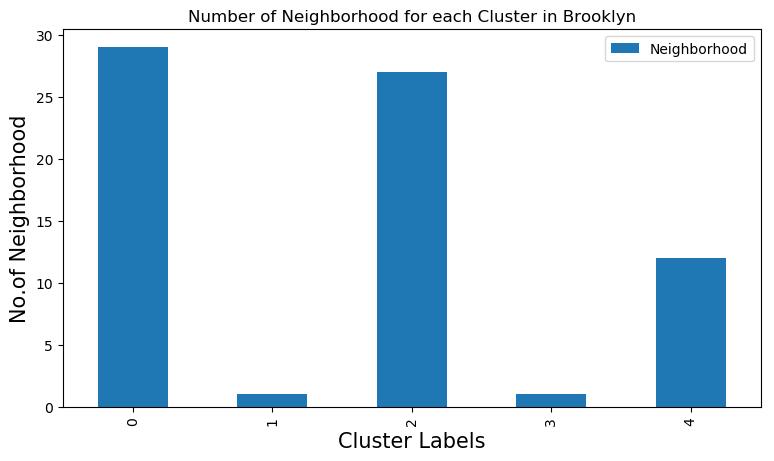

In [48]:
plt.figure(figsize=(9,5), dpi = 100)
# title
plt.title('Number of Neighborhood for each Cluster in Brooklyn')
#On x-axis
plt.xlabel('Cluster', fontsize = 15)
#On y-axis
plt.ylabel('No.of Neighborhood', fontsize=15)
#giving a bar plot
brooklyn_merged.groupby('Cluster Labels')['Neighborhood'].count().plot(kind='bar')
#legend
plt.legend()
#displays the plot
plt.show()

We can see that the first cluster (cluster_0) is the biggest with 29 neighborhoods, followed by cluster_2 with 27 neighborhoods, cluster_4 with 12 neihgborhoods and cluster_1 & cluster_3 with only 1 neighborhoods each.

In [49]:
from folium import plugins
from folium.plugins import HeatMap

brooklyn_heatmat = folium.Map(location=[40.6501038, -73.9495823], zoom_start=11) 

# List comprehension to make out list of lists
heat_data = [[row['Latitude'], 
              row['Longitude']] for index, row in brooklyn_merged.iterrows()]

# Plot it on the map
HeatMap(heat_data,
        min_opacity=0.5,
        max_zoom=18, 
        max_val=1.0, 
        radius=15,
        blur=20,
        gradient=None,
        overlay=True).add_to(brooklyn_heatmat)

# Display the map
brooklyn_heatmat

The heat map shows that especially the center and the north western region are filled with venues. this information has to implications for the decision where to open a new venue. One can argue that these areas are already crowded with venues and make it more difficult to open a new venues since the competition is gonna be fierce. On the other hand one could argue that these area might be the best once, because of the existing reasons they draw the most attention and with that possible costumers.

## Here just the test with only the 3 most common venues to verify the picture above

In [50]:
brooklyn_merged_2 = brooklyn_merged.drop(['Cluster Labels', '4th Most Common Venue',
                                    '5th Most Common Venue',
                                     '6th Most Common Venue',
                                     '7th Most Common Venue',
                                     '8th Most Common Venue', '9th Most Common Venue', '10th Most Common Venue'], axis=1)
brooklyn_merged_2.head()

,Borough,Neighborhood,Latitude,Longitude,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue
0,Brooklyn,Bay Ridge,40.625801,-74.030621,Italian Restaurant,Pizza Place,Spa
1,Brooklyn,Bensonhurst,40.611009,-73.995180,Chinese Restaurant,Park,Italian Restaurant
2,Brooklyn,Sunset Park,40.645103,-74.010316,Mexican Restaurant,Bakery,Latin American Restaurant
3,Brooklyn,Greenpoint,40.730201,-73.954241,Bar,Pizza Place,Cocktail Bar
4,Brooklyn,Gravesend,40.595260,-73.973471,Italian Restaurant,Pizza Place,Bus Station


In [51]:
# set number of clusters
kclusters = 5

brooklyn2_grouped_clustering = brooklyn_grouped.drop('Neighborhood', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=2).fit(brooklyn2_grouped_clustering)

# check cluster labels generated for each row in the dataframe
#kmeans.labels_[0:10] 
kmeans.labels_

# add clustering labels
brooklyn_merged_2['Cluster Labels'] = kmeans.labels_

brooklyn_merged_2.head()

,Borough,Neighborhood,Latitude,Longitude,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,Cluster Labels
0,Brooklyn,Bay Ridge,40.625801,-74.030621,Italian Restaurant,Pizza Place,Spa,0
1,Brooklyn,Bensonhurst,40.611009,-73.995180,Chinese Restaurant,Park,Italian Restaurant,2
2,Brooklyn,Sunset Park,40.645103,-74.010316,Mexican Restaurant,Bakery,Latin American Restaurant,2
3,Brooklyn,Greenpoint,40.730201,-73.954241,Bar,Pizza Place,Cocktail Bar,2
4,Brooklyn,Gravesend,40.595260,-73.973471,Italian Restaurant,Pizza Place,Bus Station,0


In [52]:
# create map
map_clusters_2 = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i+x+(i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(brooklyn_merged_2['Latitude'], brooklyn_merged_2['Longitude'], brooklyn_merged_2['Neighborhood'], brooklyn_merged_2['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters_2)
       
map_clusters_2

(shows the same clusters as above)

In [57]:
brooklyn_cluster_0['1st Most Common Venue'].value_counts()

Pizza Place            5
Italian Restaurant     4
Coffee Shop            3
Fried Chicken Joint    3
Bank                   2
Restaurant             1
Chinese Restaurant     1
Harbor / Marina        1
Dessert Shop           1
Spa                    1
Deli / Bodega          1
Donut Shop             1
Bus Stop               1
Café                   1
Yoga Studio            1
Ice Cream Shop         1
Bar                    1
Name: 1st Most Common Venue, dtype: int64

In [58]:
brooklyn_cluster_1['1st Most Common Venue'].value_counts()

Liquor Store    1
Name: 1st Most Common Venue, dtype: int64

In [59]:
brooklyn_cluster_2['1st Most Common Venue'].value_counts()

Bar                     5
Deli / Bodega           3
Pizza Place             3
Caribbean Restaurant    1
Locksmith               1
Art Gallery             1
Chinese Restaurant      1
Beach                   1
Food Truck              1
Grocery Store           1
Burger Joint            1
Italian Restaurant      1
Ice Cream Shop          1
Coffee Shop             1
Department Store        1
Metro Station           1
Park                    1
Mexican Restaurant      1
Bank                    1
Name: 1st Most Common Venue, dtype: int64

In [60]:
brooklyn_cluster_2['1st Most Common Venue'].value_counts()

Bar                     5
Deli / Bodega           3
Pizza Place             3
Caribbean Restaurant    1
Locksmith               1
Art Gallery             1
Chinese Restaurant      1
Beach                   1
Food Truck              1
Grocery Store           1
Burger Joint            1
Italian Restaurant      1
Ice Cream Shop          1
Coffee Shop             1
Department Store        1
Metro Station           1
Park                    1
Mexican Restaurant      1
Bank                    1
Name: 1st Most Common Venue, dtype: int64

In [61]:
brooklyn_cluster_3['1st Most Common Venue'].value_counts()

Caribbean Restaurant    1
Name: 1st Most Common Venue, dtype: int64

In [62]:
brooklyn_cluster_4['1st Most Common Venue'].value_counts()

Caribbean Restaurant    3
Asian Restaurant        2
Diner                   1
Fried Chicken Joint     1
Pharmacy                1
Discount Store          1
Pizza Place             1
Supermarket             1
Coffee Shop             1
Name: 1st Most Common Venue, dtype: int64

From the numbers above we can draw some conclusions regarding the most frequent venues in each cluster:
- brooklyn_cluster_0 is mainly populated by pizza places, italian restaurants, coffee shops and chicken joints. Because of that we can conclude that the people there love to go out to eat. From the two most frequent venues we can assume that the people who visit the venues from this cluster like to eat italian food. 
- brooklyn_cluster_1 includes only one store which is a liquor store. Because of this, the second cluster does not seem to be a good fit.
- brooklyn_cluster_2 contains mostly bars, deli / bodegas and pizza places. This cluster covers venues for more outgoing people who like to drink. But delis / bodegas are not a good representation for venues where people would like to stay for longer and enjoy some food. Therefor the third cluster might not be the best fit.Peolpe their like to go out, but restaurants are not their highest preference. 
- brooklyn_cluster_3 like cluster 2 this cluster only includes one venues,  a carribean restaurant. This might resemble a good fit, but there can be better options out there.
- brooklyn_cluster_4 is dominated by carribean restaurants and asian restaurants. This cluster seems to be a good fit for a restaurant. 

## Results

The used methods have shown that brooklyn_cluster_4 is characterised by a lot of restaurants and bears the potential to be a good place to open a new restaurant. Other clusters tend to be more populated with bars and places like supermarkets which are not a good fit to open a new restaurant. Cluster 5 consists of 12 neighborhoods. On the map they are marked as orange dots, that are pretty close together and not spread out like other clusters. This indicated that these neighborhoods are pretty similar. They tend to have similar people living there which is a really important aspect if you want to attract as many people as possible to your restaurant. It is much more convenient for the people to have a venue in their close proximity! Compared with the heat map we can see that cluster 5 (brooklyn_cluster_4) is not directly among the most heated areas. Tis is also an important aspect. Since the goal is to open a new venue,it is important to have an overview of the existing situation. If the current market is already flooded with venues (in this particular case with restaurants) it becomes way more difficult to establish a new venue. The market competition is fierce and to attract customers in a new environment is nearly impossible. 

## Discussion

The used methodologies helped to narrow down the decision making process. One cluster showed itself as a potential area for a new venue opening. But it remains to say that the results are just an approximation and resemble only one single approach to solve the problem. The approach depends on a rather small dataset. For further research it might be usefull to take more sources into consideration, like population within the neighborhoods as well as the different rent prices (like the average rent per neighborhood). Second to that the decision for the cluster was mainly based on the most frequent venues within each neighborhood. To make create a more rounded picture it would help to further include the less frequent venues.

## Conclusion

All in all we can say that the used approach helped to answer the key questions and definitely helped me in my decison making process. The used methods helped to gain important insights. Overall I am happy with my Coursera experience and I would advice others to take the time to learn and do the courses. Data science has appeared more and more frequently in my daily life. Since I took the courses my understanding for Data Science has improved a lot and I was able to solve little personal problems and projects!